In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
filenames = ['YoutubeSpamCollection/Youtube01-Psy.csv',
             'YoutubeSpamCollection/Youtube02-KatyPerry.csv',
             'YoutubeSpamCollection/Youtube03-LMFAO.csv',
             'YoutubeSpamCollection/Youtube04-Eminem.csv', 'YoutubeSpamCollection/Youtube05-Shakira.csv']

In [3]:
dataframes = []
for file in filenames:
    dataframes.append(pd.read_csv(file))

In [4]:
# Combine all the dataframes into one
yt_reviews = pd.concat(dataframes)

In [5]:
yt_reviews['TEXT LENGTH'] = yt_reviews['CONTENT'].apply(len)

In [6]:
yt_reviews.head()

,COMMENT_ID,AUTHOR,DATE,CONTENT,CLASS,TEXT LENGTH
0,LZQPQhLyRh80UYxNuaDWhIGQYNQ96IuCg-AYWqNPjpU,Julius NM,2013-11-07T06:20:48,"Huh, anyway check out this you[tube] channel: ...",1,56
1,LZQPQhLyRh_C2cTtd9MvFRJedxydaVW-2sNg5Diuo4A,adam riyati,2013-11-07T12:37:15,Hey guys check out my new channel and our firs...,1,166
2,LZQPQhLyRh9MSZYnf8djyk0gEF9BHDPYrrK-qCczIY8,Evgeny Murashkin,2013-11-08T17:34:21,just for test I have to say murdev.com,1,38
3,z13jhp0bxqncu512g22wvzkasxmvvzjaz04,ElNino Melendez,2013-11-09T08:28:43,me shaking my sexy ass on my channel enjoy ^_^ ﻿,1,48
4,z13fwbwp1oujthgqj04chlngpvzmtt3r3dw,GsMega,2013-11-10T16:05:38,watch?v=vtaRGgvGtWQ Check this out .﻿,1,39


In [7]:
yt_reviews.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1956 entries, 0 to 369
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   COMMENT_ID   1956 non-null   object
 1   AUTHOR       1956 non-null   object
 2   DATE         1711 non-null   object
 3   CONTENT      1956 non-null   object
 4   CLASS        1956 non-null   int64 
 5   TEXT LENGTH  1956 non-null   int64 
dtypes: int64(2), object(4)
memory usage: 107.0+ KB


In [8]:
yt_reviews.describe()

,CLASS,TEXT LENGTH
count,1956.000000,1956.000000
mean,0.513804,94.700920
std,0.499937,128.222062
min,0.000000,2.000000
25%,0.000000,29.000000
50%,1.000000,48.000000
75%,1.000000,97.000000
max,1.000000,1200.000000


# Exploratory Data Analysis

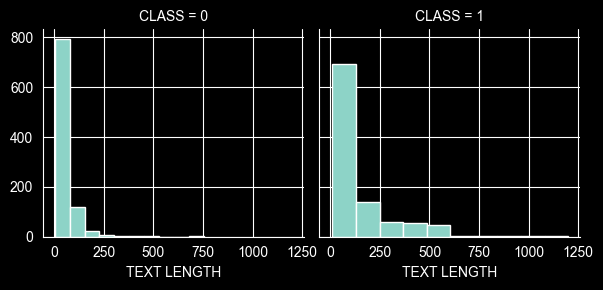

In [9]:
g=sns.FacetGrid(yt_reviews, col='CLASS', palette='Set1')
g.map(plt.hist,'TEXT LENGTH')

<Axes: xlabel='CLASS', ylabel='TEXT LENGTH'>

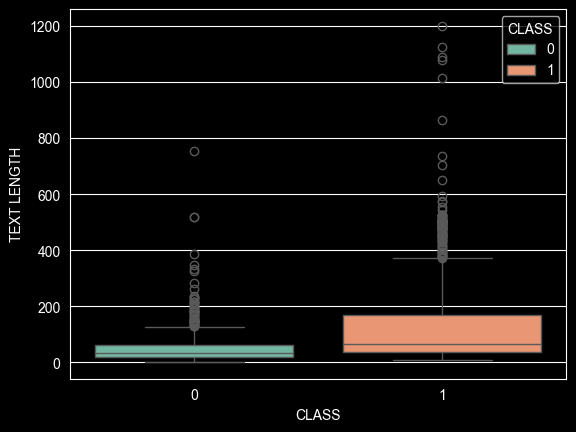

In [10]:
sns.boxplot(data=yt_reviews, x='CLASS', y='TEXT LENGTH', hue='CLASS', palette='Set2')

<Axes: xlabel='CLASS', ylabel='count'>

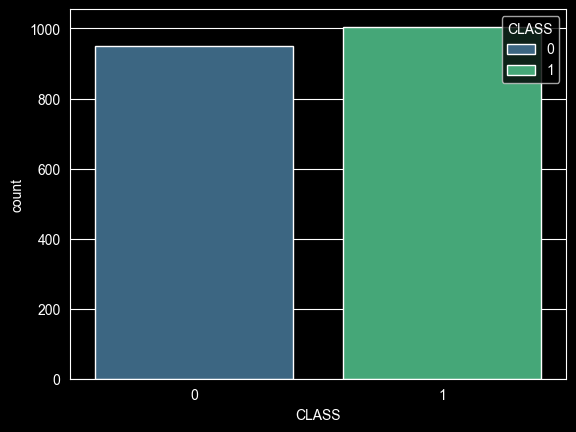

In [11]:
sns.countplot(data=yt_reviews, x='CLASS', hue='CLASS', palette='viridis')

In [12]:
yt_corr = yt_reviews[['CLASS','TEXT LENGTH']].corr()

<Axes: >

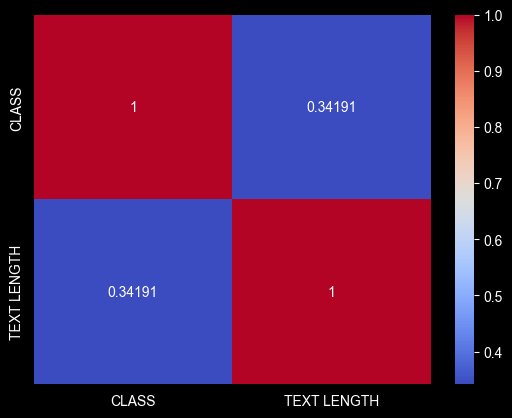

In [13]:
sns.heatmap(data=yt_corr, annot=True, cmap='coolwarm' ,fmt='g')

# Text Preprocessing

In [14]:
import string
import nltk
from nltk.corpus import stopwords

In [15]:
stop_words = set(stopwords.words('english'))
keep_words = {'my', 'out', 'check', 'your', 'our'}
custom_stop_words = stop_words - keep_words

In [16]:
def textPreprocess(messy_string):
    messy_string = messy_string.lower()
    nopunc = []
    for char in messy_string:
        if(char not in string.punctuation):
            nopunc.append(char)

    nopunc = ''.join(nopunc)

    words = []
    for word in nopunc.split():
        if(word not in custom_stop_words):
            words.append(word)
    return words

In [17]:
yt_reviews['PROCESSED'] = yt_reviews['CONTENT'].apply(textPreprocess)

In [18]:
yt_reviews['PROCESSED'] = yt_reviews['PROCESSED'].apply(lambda x : ' '.join(x))

In [19]:
yt_reviews['PROCESSED'].head()

0      huh anyway check out youtube channel kobyoshi02
1    hey guys check out my new channel our first vi...
2                                   test say murdevcom
3               shaking my sexy ass my channel enjoy ﻿
4                        watchvvtarggvgtwq check out ﻿
Name: PROCESSED, dtype: object

# Vectorization

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer

In [21]:
tfidf=TfidfVectorizer()

In [22]:
X = tfidf.fit_transform(yt_reviews['PROCESSED'])
y = yt_reviews['CLASS']

In [23]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 101)

In [24]:
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()
nb.fit(X_train,y_train)

,"alpha alpha: float or array-like of shape (n_features,), default=1.0Additive (Laplace/Lidstone) smoothing parameter(set alpha=0 and force_alpha=True, for no smoothing).",1.0
,"force_alpha force_alpha: bool, default=TrueIf False and alpha is less than 1e-10, it will set alpha to1e-10. If True, alpha will remain unchanged. This may causenumerical errors if alpha is too close to 0... versionadded:: 1.2.. versionchanged:: 1.4 The default value of `force_alpha` changed to `True`.",True
,"fit_prior fit_prior: bool, default=TrueWhether to learn class prior probabilities or not.If false, a uniform prior will be used.",True
,"class_prior class_prior: array-like of shape (n_classes,), default=NonePrior probabilities of the classes. If specified, the priors are notadjusted according to the data.",None


In [25]:
preds = nb.predict(X_test)

In [26]:
from sklearn.metrics import classification_report, confusion_matrix

In [27]:
print(confusion_matrix(y_test,preds))

[[162  12]
 [ 34 184]]


In [28]:
print(classification_report(y_test,preds))

              precision    recall  f1-score   support

           0       0.83      0.93      0.88       174
           1       0.94      0.84      0.89       218

    accuracy                           0.88       392
   macro avg       0.88      0.89      0.88       392
weighted avg       0.89      0.88      0.88       392



# Using a Pipeline

In [29]:
from sklearn.pipeline import Pipeline

In [30]:
pipe = Pipeline([
    ('bow', CountVectorizer(tokenizer=textPreprocess, token_pattern=None)),
    ('tfidf', TfidfTransformer()),
    ('classifier', MultinomialNB()),
])

In [31]:
X = yt_reviews['CONTENT']
y = yt_reviews['CLASS']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 101)

In [32]:
pipe.fit(X_train,y_train)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('bow', ...), ('tfidf', ...), ...]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"input input: {'filename', 'file', 'content'}, default='content'- If `'filename'`, the sequence passed as an argument to fit is expected to be a list of filenames that need reading to fetch the raw content to analyze.- If `'file'`, the sequence items must have a 'read' method (file-like object) that is called to fetch the bytes in memory.- If `'content'`, the input is expected to be a sequence of items that can be of type string or byte.",'content'
,"encoding encoding: str, default='utf-8'If bytes or files are given to analyze, this encoding is used todecode.",'utf-8'
,"decode_error decode_error: {'strict', 'ignore', 'replace'}, default='strict'Instruction on what to do if a byte sequence is given to analyze thatcontains characters not of the given `encoding`. By default, it is'strict', meaning that a UnicodeDecodeError will be raised. Othervalues are 'ignore' and 'replace'.",'strict'
,"strip_accents strip_accents: {'ascii', 'unicode'} or callable, default=NoneRemove accents and perform other character normalizationduring the preprocessing step.'ascii' is a fast method that only works on characters that havea direct ASCII mapping.'unicode' is a slightly slower method that works on any characters.None (default) means no character normalization is performed.Both 'ascii' and 'unicode' use NFKD normalization from:func:`unicodedata.normalize`.",None
,"lowercase lowercase: bool, default=TrueConvert all characters to lowercase before tokenizing.",True
,"preprocessor preprocessor: callable, default=NoneOverride the preprocessing (strip_accents and lowercase) stage whilepreserving the tokenizing and n-grams generation steps.Only applies if ``analyzer`` is not callable.",None
,"tokenizer tokenizer: callable, default=NoneOverride the string tokenization step while preserving thepreprocessing and n-grams generation steps.Only applies if ``analyzer == 'word'``.",<function tex...t 0x117a8eb90>


In [33]:
pipe_preds = pipe.predict(X_test)

In [34]:
pipe_cm = confusion_matrix(y_test,pipe_preds)
print(pipe_cm)

[[147  27]
 [ 21 197]]


In [35]:
pipe_cr = classification_report(y_test,pipe_preds)
print(pipe_cr)

              precision    recall  f1-score   support

           0       0.88      0.84      0.86       174
           1       0.88      0.90      0.89       218

    accuracy                           0.88       392
   macro avg       0.88      0.87      0.88       392
weighted avg       0.88      0.88      0.88       392

